In [144]:
from psycopg2 import connect
import pandas.io.sql as pandasql
import pandas as pd
import configparser
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib as mpl
import copy
import matplotlib.dates as mdates
import time

CONFIG = configparser.ConfigParser()
CONFIG.read('C:\\Users\\rrodger\\reed.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [220]:
basql_15 = '''
SELECT datetime_bin::time as time, 
    percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.tt) as travel_time,
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
    aa.report_name

FROM bluetooth.aggr_15min bt
    INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL
    AND left(aa.report_name, 4) = 'DT-0'

GROUP BY aa.report_name, 
    datetime_bin::time, 
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
'''
travelsql_15 = '''
SELECT bt.tt as travel_time, 
	bt.datetime_bin, 
	bt.analysis_id,
	EXTRACT(ISODOW FROM datetime_bin) as weekday,
	aa.report_name
    
FROM bluetooth.aggr_15min bt
	INNER JOIN bluetooth.all_analyses aa ON (bt.analysis_id = aa.analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL
    AND left(aa.report_name, 4) = 'DT-0'
'''
baselines_15 = pandasql.read_sql(basql_15, con)
traveltime_15 = pandasql.read_sql(travelsql_15, con)


from the fifteen minute aggregated data, these queries fetch a baseline for working and nonworking days, and the bulk travel time data. 

In [277]:
colors = ['#003A72', '#d83904']

In [5]:
r_name = 'DT-0019. Queen-EB_Roncesvalles-to-Dufferin'

In [327]:
def plot_base(observations):
    #Divide data into Week and Weekend buckets for the given route name. 
    segments = {'Week' : observations[(observations['report_name'] == r_name) & 
                         (observations['workingday'] == 'Work')].sort_values(['time']),
                'Weekend' : observations[(observations['report_name'] == r_name) & 
                         (observations['workingday'] == 'Weekend')].sort_values(['time'])}
        
        
    fig, work = plt.subplots(1, 1, figsize = (16,14))
    
    weekend = work.twinx()
    weekend = work.twiny()
    days = [work, weekend]
    
    for i, (color, WD) in enumerate(zip(colors, ['Weekend', 'Week'])):        

        days[i].plot_date(x = segments[WD].time,
                          y = segments[WD].travel_time,
                          xdate = True,
                          fmt = '-o',
                          c = color,
                          label = WD)
        days[i].legend()

            
    days[1].get_xaxis().set_visible(False)
    days[1].get_yaxis().set_visible(False)
    
    plt.title('Baseline for ' + r_name + ' by Working Day')
    
    days[1].xaxis.set_label_text('Time')
    days[1].yaxis.set_label_text('Travel Time')
    
    plt.gcf().autofmt_xdate()
    plt.show()

In [212]:
basql_30 = '''
SELECT datetime_bin::time as time, 
    percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.travel_time) as travel_time,
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
    aa.report_name

FROM dt_30min_agg bt
    INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL

GROUP BY aa.report_name, 
    datetime_bin::time, 
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
'''
travelsql_30 = '''
SELECT bt.travel_time, 
	bt.datetime_bin, 
	bt.analysis_id,
	EXTRACT(ISODOW FROM datetime_bin) as weekday,
	aa.report_name
FROM dt_30min_agg bt
	INNER JOIN bluetooth.all_analyses aa ON (bt.analysis_id = aa.analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL
'''
baselines_30 = pandasql.read_sql(basql_30, con)
traveltime_30 = pandasql.read_sql(travelsql_30, con)

Fifteen minute buckets


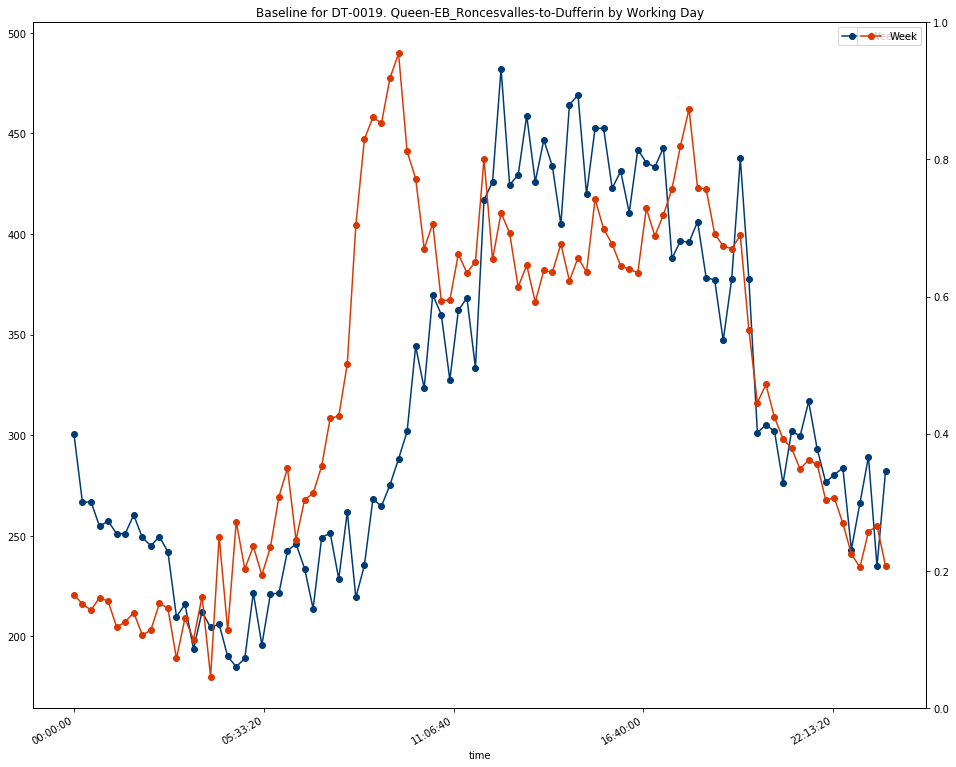

Thirty minute buckets


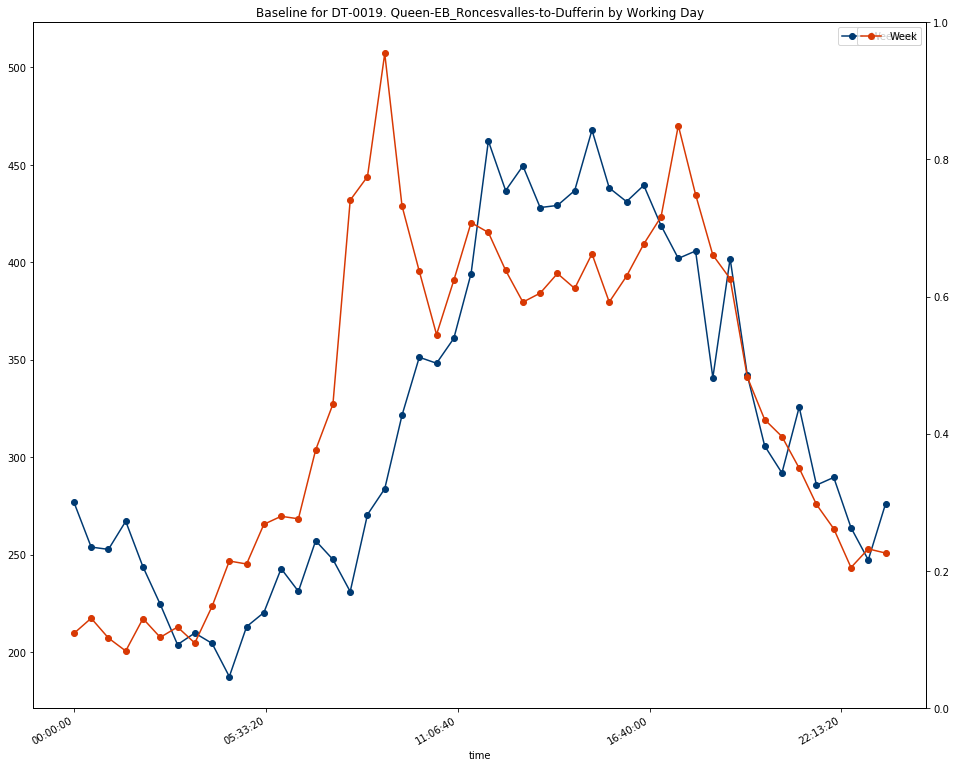

In [328]:
print('Fifteen minute buckets')
plot_base(baselines_15)
print('Thirty minute buckets')
plot_base(baselines_30)

The fifteen minute bucket baseline seems to vary rapidly and is therefore difficult to interpret. Changing to month aggregation makes for a much cleaner graph.

In [222]:
def WOY(x, W):
    return x.weekofyear == W

weeks = {W : traveltime_30[(traveltime_30['report_name'] == r_name) & 
             traveltime_30['datetime_bin'].apply(WOY, args = (W,))]
        for W in traveltime_30.datetime_bin.apply(lambda x : x.weekofyear).unique()}

Creates a dictionary to store the bluetoothe observations (30 minute) divided by week.

In [223]:
temp = {}
for week, df in weeks.items():
    if not df.empty:
        temp[week] = weeks[week]
weeks = temp

Removes empty weeks to keep the graph clean

In [317]:
fig, ax = plt.subplots(len(weeks.keys()), 1, sharex = False, sharey = True, figsize = (16, 16))
plt.suptitle('Travel times by week for ' + r_name)
for i, week in enumerate(weeks):
    ax[i].plot_date(x = weeks[week].datetime_bin,
                    y = weeks[week].travel_time)
    
    ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday = range(0,7), interval=1))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('\n%a %Y-%m-%d'))
    ax[i].xaxis.set_minor_locator(mdates.HourLocator(interval=4))
    ax[i].xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
    
    ax[i].set_title(str(week))
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Travel Time')
    ax[i].legend()
    ax[i].xaxis.grid(True, which="major")
    
fig.tight_layout()

#st.set_y(0.95)
fig.subplots_adjust(top=0.95)
  #  print(week)
   # print(i)
    #make some graphs

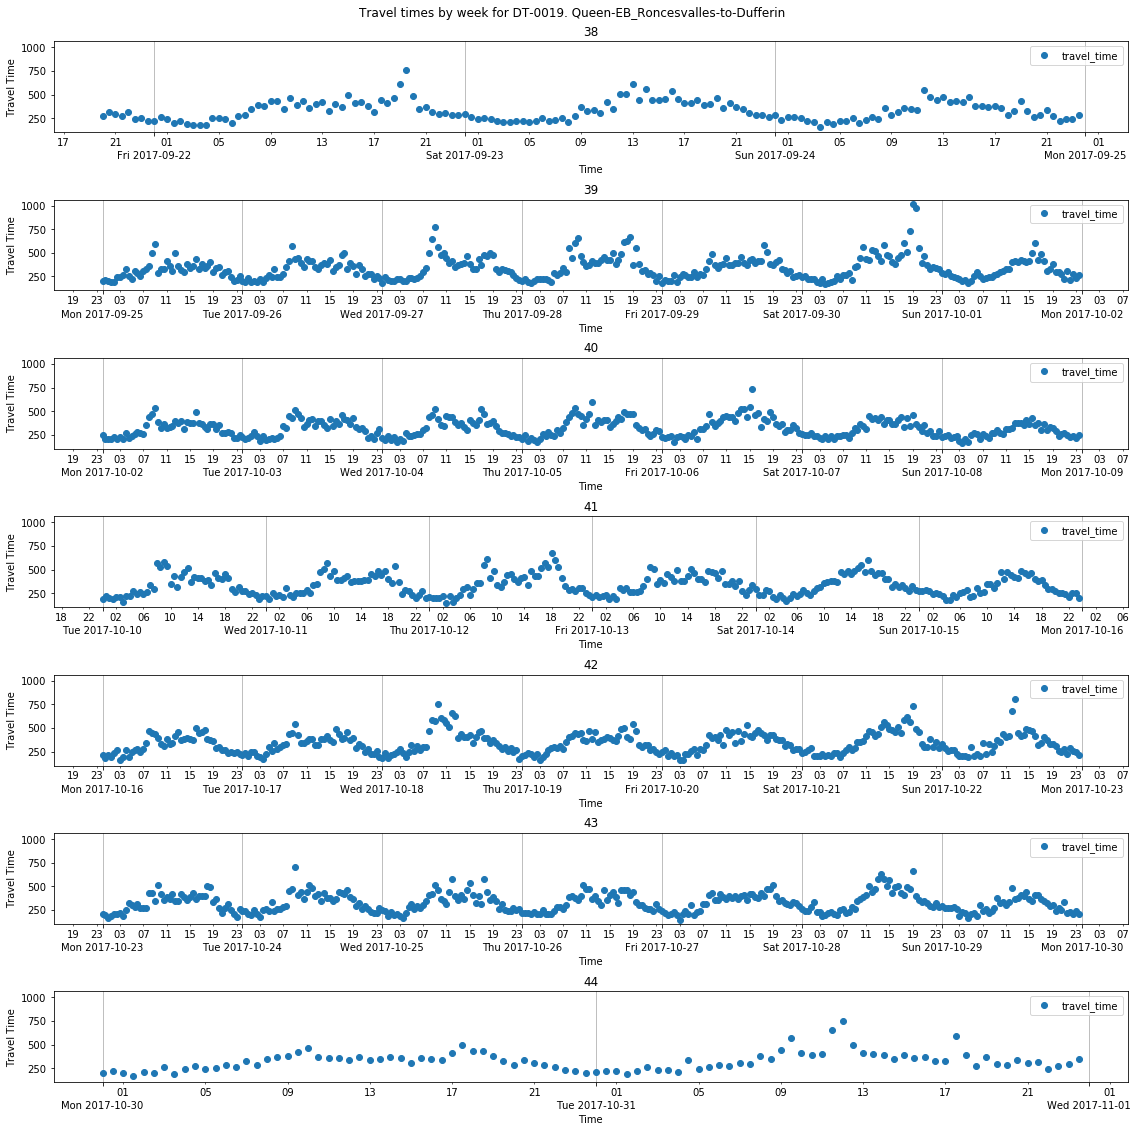

In [318]:
plt.show()

On this segment, there seems to be suspicious data in a number of places, though it's sometimes difficult to tell if it's this is due to peak time. I've removed some of the more suspicious days, listed below.

In [319]:
cut_days = ['2017-09-22', '2017-09-07', '2017-09-30', '2017-10-12', '2017-10-18', '2017-10-22']
colors = ['#003A72', '#d83904']

In [320]:
cut_day_str = '(\'' + cut_days[0]
for day in cut_days[1:]:
    cut_day_str = cut_day_str + '\', \'' + day
cut_day_str = cut_day_str + '\')'

In [321]:
sql_mod = '''
WITH bt as(
SELECT * 
FROM dt_30min_agg blu
WHERE blu.datetime_bin::date NOT IN {}
)
SELECT EXTRACT(YEAR FROM datetime_bin) as year, 
    datetime_bin::time as time, 
    percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.travel_time) as travel_time,
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
    aa.report_name

FROM  bt
    INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL

GROUP BY aa.report_name, 
    datetime_bin::time, 
    EXTRACT(YEAR FROM datetime_bin),
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
'''.format(cut_day_str)

new_base = pandasql.read_sql(sql_mod, con)

In [ ]:
The baseline query from above, modified to exclude anomalistic dates.

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


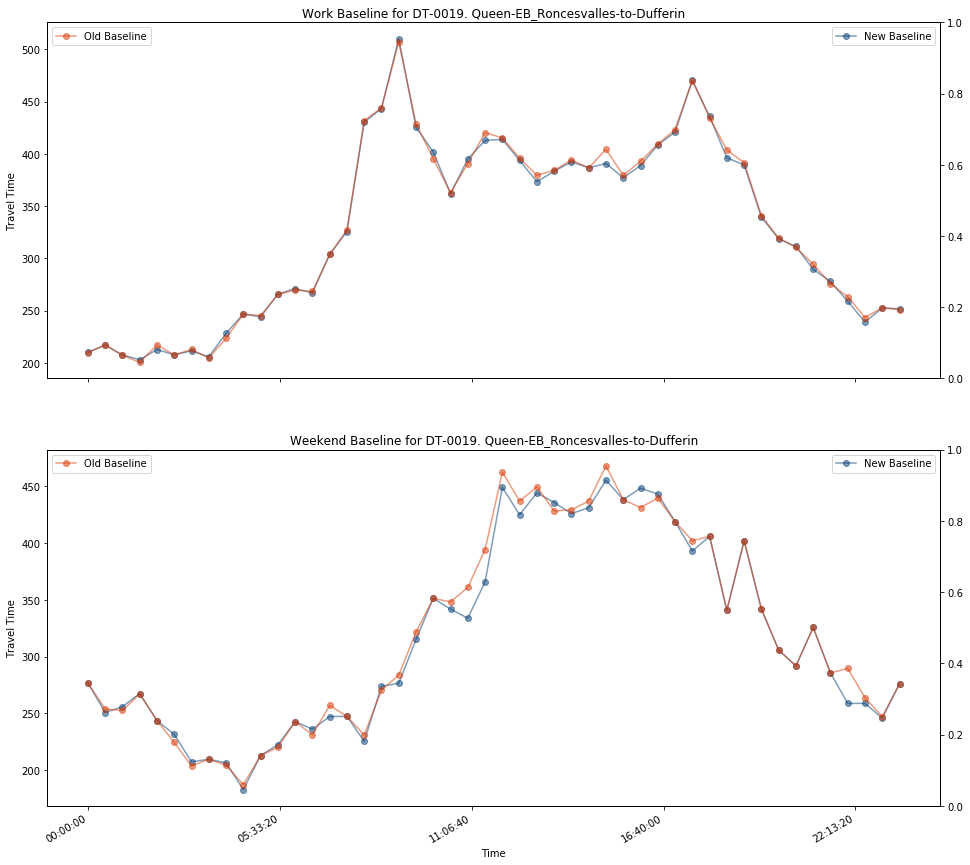

In [325]:
fig, days = plt.subplots(2, 1, figsize = (16,16))
old = []

segments = {order : {'Work' : observations[(observations['report_name'] == r_name) & 
                                           (observations['workingday'] == 'Work')].sort_values(['time']),
                     'Weekend' : observations[(observations['report_name'] == r_name) & 
                                                (observations['workingday'] == 'Weekend')].sort_values(['time'])}
            for order, observations in zip(['New', 'Old'],[new_base, baselines_30])}


for i, WD in enumerate(['Work', 'Weekend']):
    old.append(days[i].twinx())
    old[i] = days[i].twiny()
    days[i].plot_date(x = segments['New'][WD].time,
                      y = segments['New'][WD].travel_time,
                      xdate = True,
                      fmt = '-o',
                      c = colors[0],
                      alpha = 0.5,
                      label = 'New Baseline')
    plt.legend()
    old[i].plot_date(x = segments['Old'][WD].time,
                     y = segments['Old'][WD].travel_time,
                     xdate = True,
                     fmt = '-o',
                     c = colors[1],
                     alpha = 0.5,
                     label = 'Old Baseline')
    
    old[i].get_xaxis().set_visible(False)
    old[i].get_yaxis().set_visible(False)
    
    plt.title(str(WD) + ' Baseline for ' + r_name)
    days[i].xaxis.set_label_text('Time')
    days[i].yaxis.set_label_text('Travel Time')
    days[i].legend()
    old[i].legend(loc = 'upper left')
    
    #days[i].xaxis.set_major_locator(mdates.HourLocator(byhour = range(0, 23 ,1)))
    #days[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.gcf().autofmt_xdate()

plt.show()

With the anomalous days removed, the baseline is still fairly close to what it was originally. 